In [1]:
from numpy import *
from matplotlib.pylab import *
import random
import sys
import io
import os
import glob
import h5py

import IPython

#from pydub import AudioSegment
from td_utils import *

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [133]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Concatenate
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.layers import MaxPooling2D, MaxPooling3D, AveragePooling2D, AveragePooling3D
from keras.layers import Conv2D,Conv3D, Lambda
from keras.backend import transpose
from keras.optimizers import Adam
from keras import regularizers

(10, 10, 4000)


<Figure size 432x288 with 0 Axes>

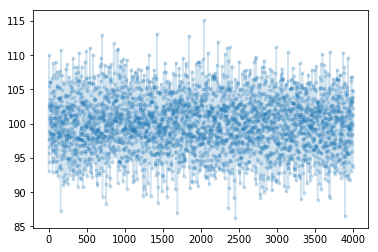

<Figure size 432x288 with 0 Axes>

In [3]:
i = randint(0,900)
home = "/export/home1/users/bssn/serna"
datadir = home+"/SyntheticData/syndat/"
Ft = load(datadir+"d"+str(i).zfill(4)+".npy")

Ftsh = Ft.shape
width,height,T = Ftsh  
print(Ftsh)
t = arange(Ftsh[-1])
figure()
plot(t,sum(sum(Ft,axis=0),axis=0),'.-',alpha=0.2)
figure()

In [4]:
def get_random_time_segment(segment_frames,total_frames=12000):
    '''
    Gets a random time segment of duration segment_frames in a file
    with number of frames: total_frames
    '''
    
    segment_start = randint(0, high = total_frames-
                                   segment_frames)
    segment_end = segment_start + segment_frames
    
    return (segment_start, segment_end)

In [5]:
def is_overlapping(segment_time, previous_segments):
    '''
    This function checks if the time of a segment overlaps with the
    existing segments.
    '''
    s_start, s_end = segment_time
    
    overlap = False
    
    for prev_start, prev_end in previous_segments:
        if s_start <= prev_end and s_end >= prev_start:
            overlap = True
    
    return overlap

## Loading data set.

This is a big dataset, so we are going to divide it in 4000 samples for  training set and 100 dev_set and 100 test_set.

In [6]:
from scipy.fftpack import fft2,fftshift,ifftshift,ifft2

def ftaugment(img,magn=2):
    sh = img.shape
    sh2 = (sh*(magn-1))
    sh2 = ((sh2[0])//2,(sh2[1])//2)
    fftim  = fftshift(fft2(img))
    fftim  =  pad(fftim,(sh2[0],sh2[1]),'constant')    
    imgn = real(ifft2(ifftshift(fftim)))
    return(imgn)

def ftvaugment(img,magn=2):
    sh = img.shape
    sh2 = (sh*(magn-1))
    sh2 = ((sh2[0])//2,(sh2[0])//2)
    fftim  = fftshift(fft2(img,axes=(0,1)),axes=(0,1))
    fftim  =  pad(fftim,(sh2[0],sh2[1]),'constant')    
    imgn = real(ifft2(ifftshift(fftim,axes=(0,1)),axes=(0,1)))
    imgn = imgn[:,:,sh2[0]:-sh2[0]]
    return(imgn)

In [221]:
# 1 segundo. This will be used as another (meta)parameter, 
# which we want to decrease
nframes = 500
magn=2

X = []
Y = []
for i in range(800):
    xt = load(datadir+"d"+str(i).zfill(4)+".npy")
    yt = load(datadir+"o2_"+str(i).zfill(4)+".npy")
    xt = xt/mean(xt.flatten())
    xt = ftvaugment(xt,magn)
    ymax = max(1,max(yt.flatten()))
    yt = yt
    #par = pars[i]
    #xt = reshape(xt,(width*height,T))
    #yt = reshape(yt,(4*width*height))
    for j in range(10):
        start,end = get_random_time_segment(nframes,T)
        X.append(xt[:,:,start:end])
        #Y.append(concatenate((yt[start:end],par[-1:])))
        ytr = 0.05*ymax*randn(magn*width,magn*height)
        Y.append((yt+ytr)/ymax)
    if i %200 == 0:
        print("Iteracion #",i)
X = array(X)
Y = array(Y)
print(X.shape, Y.shape)
    

Xdev = []
Ydev = []
for i in range(800,900):
    xt = load(datadir+"d"+str(i).zfill(4)+".npy")
    yt = load(datadir+"o2_"+str(i).zfill(4)+".npy")
    xt = xt/mean(xt.flatten())
    xt = ftvaugment(xt,magn)
    
    ymax = max(1,max(yt.flatten()))
    yt = yt
    #par = pars[i]
    #xt = reshape(xt,(width*height,T))
    #yt = reshape(yt,(4*width*height))
    for j in range(5):
        start,end = get_random_time_segment(nframes,T)
        Xdev.append(xt[:,:,start:end])
        #Ydev.append(concatenate((yt[start:end],par[-1:])))
        ytr = 0.05*ymax*randn(magn*width,magn*height)
        Ydev.append((yt+ytr)/ymax)
Xdev = array(Xdev)
Ydev = array(Ydev)

print(Xdev.shape, Ydev.shape)


'''
Xdev = array(X).transpose()
Ydev = array(Y).transpose()
for i in range(4000,4100):
    xt = load("syndat/d"+str(i).zfill(4)+".npy")
    yt = load("syndat/r"+str(i).zfill(4)+".npy")
    for j in range(20):
        start,end = get_random_time_segment(nframes)
        Xdev.append(xt[start:end])
        Ydev.append(yt[start:end])
'''        
        

Iteracion # 0
Iteracion # 200
Iteracion # 400
Iteracion # 600
(8000, 20, 20, 500) (8000, 20, 20)
(500, 20, 20, 500) (500, 20, 20)


'\nXdev = array(X).transpose()\nYdev = array(Y).transpose()\nfor i in range(4000,4100):\n    xt = load("syndat/d"+str(i).zfill(4)+".npy")\n    yt = load("syndat/r"+str(i).zfill(4)+".npy")\n    for j in range(20):\n        start,end = get_random_time_segment(nframes)\n        Xdev.append(xt[start:end])\n        Ydev.append(yt[start:end])\n'

In [222]:
X.shape

(8000, 20, 20, 500)

5119


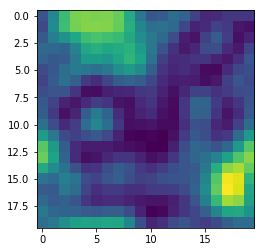

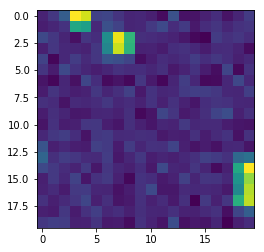

In [223]:
colors = array(['C0','C1'])
t = arange(1000)
# We plot some random pieces we chose to fit the network!

i = randint(0,X.shape[0])
imshow(sum(X[i,:,:],axis=-1))
figure()
imshow(Y[i,:])
print(i)

In [224]:
print(X.shape)
print(Y.shape)
print(Xdev.shape)
print(Ydev.shape)
width

(8000, 20, 20, 500)
(8000, 20, 20)
(500, 20, 20, 500)
(500, 20, 20)


10

## Definition of the network

Here, we define the neural network. We may start with just nframes logistic regressions?!

In [225]:
X = reshape(X,(X.shape[0],X.shape[1],X.shape[2],X.shape[3],1))
Y = reshape(Y,(Y.shape[0],Y.shape[1],Y.shape[2],1,1))

Xdev = reshape(Xdev,(Xdev.shape[0],Xdev.shape[1],Xdev.shape[2],Xdev.shape[3],1))
Ydev = reshape(Ydev,(Ydev.shape[0],Ydev.shape[1],Ydev.shape[2],1,1))

In [226]:
print(X.shape,Y.shape)

(8000, 20, 20, 500, 1) (8000, 20, 20, 1, 1)


In [136]:
def model(input_shape):
    '''
    Function used to create the model's graph in Keras
    
    Argument:
    -- input_shape. Shape of the model's input data (Keras conventions?!)
    
    Returns:
    -- model. Keras model instance
    '''
    
    magn = 2
    X_input = Input(shape = input_shape)
    
    w,h,T,_ = input_shape
    # Layers

    X = X_input

    X = Conv3D(20,(2,2,50),strides=(1,1,20),padding="same")(X)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)

    X = Dropout(0.1)(X)
    X = Dense(10,activation="relu")(X)
    X = BatchNormalization()(X)

    
    Xa = MaxPooling3D((4,4,100),strides=(1,1,10),padding="same")(X)
    Xb = AveragePooling3D((4,4,100),strides=(1,1,10),padding="same")(X)
    Xc = Conv3D(10,(4,4,50),strides=(1,1,5),padding="same")(X)
    Xd = Conv3D(20,(4,4,20),strides=(1,1,5),padding="same")(X)

    Xb = Concatenate(axis=3)([Xa,Xb])
    Xc = Concatenate(axis=-1)([Xb,Xc])
    X = Concatenate(axis=4)([Xc,Xd])
    X = BatchNormalization()(X)

    #X = Dense(magn*magn*10,activation="relu")(X)
    #X = BatchNormalization()(X)

    #X = Conv3D(magn*magn*10,(1,1,20),strides=(1,1,1),padding="valid")(X)
    #X = BatchNormalization()(X)
    #X = Activation("relu")(X)
    
    X = Reshape((magn*10,magn*10,1,400//magn//magn))(X)
    #Xa = Conv1D(20,10,strides = 4,padding="same")(Xa)
    #Xa = BatchNormalization()(Xa)
    #Xa = Activation("relu")(Xa)

    #Xa = Conv1D(40,5,strides = 2,padding="same")(Xa)
    #Xa = BatchNormalization()(Xa)
    #Xa = Activation("relu")(Xa)

    #X = Dense(10,activation="relu")(Xa)
    #X = Dense(16,activation="relu")(X)
    #Xb = Dense(10,activation="softmax")(X)
    #X = Concatenate()([Xa,Xb])
    #X = Reshape((2000,2))(X)
    X = Dropout(0.7)(X)
    X = Dense(1,activation="relu")(X)

    # Defining the model
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [135]:
def model(input_shape):
    '''
    Function used to create the model's graph in Keras
    
    Argument:
    -- input_shape. Shape of the model's input data (Keras conventions?!)
    
    Returns:
    -- model. Keras model instance
    '''
    
    magn = 2
    X_input = Input(shape = input_shape)
    
    w,h,T,_ = input_shape
    # Layers

    X = X_input
    
    X = Dropout(0.9)(X)
    X = Conv3D(10,(4,4,50),strides=(1,1,10),padding="same")(X)
    X = Activation("relu")(X)
    X = BatchNormalization()(X)

    X = Dropout(0.9)(X)
    X = Conv3D(40,(4,4,10),strides=(1,1,2),padding="same")(X)
    X = Activation("relu")(X)
    X = BatchNormalization()(X)
    
    X = Dropout(0.9)(X)
    X = Dense(10,activation="relu")(X)

    X = Dropout(0.9)(X)
    X = Conv3D(10,(4,4,10),strides=(1,1,5),padding="same")(X)
    X = Activation("relu")(X)
    X = BatchNormalization()(X)   
    
    X = Dropout(0.9)(X)
    X = Conv3D(40,(1,1,10),strides=(1,1,10),padding="valid")(X)
    X = Activation("relu")(X)
    X = BatchNormalization()(X)   
    #X = Dense(magn*magn*10,activation="relu")(X)
    #X = BatchNormalization()(X)

    #X = Conv3D(magn*magn*10,(1,1,20),strides=(1,1,1),padding="valid")(X)
    #X = BatchNormalization()(X)
    #X = Activation("relu")(X)
    
    #X = Reshape((magn*10,magn*10,1,20))(X)
    
    #Xa = Conv1D(20,10,strides = 4,padding="same")(Xa)
    #Xa = BatchNormalization()(Xa)
    #Xa = Activation("relu")(Xa)

    #Xa = Conv1D(40,5,strides = 2,padding="same")(Xa)
    #Xa = BatchNormalization()(Xa)
    #Xa = Activation("relu")(Xa)

    #X = Dense(10,activation="relu")(Xa)
    #X = Dense(16,activation="relu")(X)
    #Xb = Dense(10,activation="softmax")(X)
    #X = Concatenate()([Xa,Xb])
    #X = Reshape((2000,2))(X)
    X = Dropout(0.7)(X)
    X = Dense(1,activation="relu")(X)

    # Defining the model
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [321]:
def model(input_shape):
    '''
    Function used to create the model's graph in Keras
    
    Argument:
    -- input_shape. Shape of the model's input data (Keras conventions?!)
    
    Returns:
    -- model. Keras model instance
    '''
    
    magn = 2
    X_input = Input(shape = input_shape)
    
    w,h,T,_ = input_shape
    # Layers

    X = X_input
    
    X = AveragePooling3D((1,1,20),strides=(1,1,5),padding="same")(X)
    X = BatchNormalization()(X)   

    X = Dropout(0.3)(X)
    
    X = Conv3D(40,(4,4,4),strides=(1,1,2),padding="same")(X)
    X = Activation("relu")(X)
    X = BatchNormalization()(X)
    
    X = Dropout(0.3)(X)
    X = AveragePooling3D((1,1,20),strides=(1,1,3),padding="same")(X)
    X = BatchNormalization()(X)   
   
    X = Dropout(0.3)(X)
    X = Conv3D(80,(1,1,13),strides=(1,1,17),padding="valid")(X)
    X = Activation("relu")(X)
    X = BatchNormalization()(X) 
    
    #X = Dropout(0.3)(X)
    #X = MaxPooling3D((1,1,10),strides=(1,1,1),padding="same")(X)
    #X = Activation("relu")(X)
    #X = BatchNormalization()(X) 

    #X = Dropout(0.3)(X)
    #X = Conv3D(80,(1,1,10),strides=(1,1,2),padding="valid")(X)
    #X = Activation("relu")(X)
    #X = BatchNormalization()(X) 
    
    X = Dropout(0.3)(X)
    X = Dense(1,activation="relu",kernel_regularizer=regularizers.l2(0.001),activity_regularizer=regularizers.l2(0.001))(X)

    # Defining the model
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [322]:
model = model(input_shape = (magn*width,magn*height,nframes,1))

In [323]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 20, 20, 500, 1)    0         
_________________________________________________________________
average_pooling3d_21 (Averag (None, 20, 20, 100, 1)    0         
_________________________________________________________________
batch_normalization_105 (Bat (None, 20, 20, 100, 1)    4         
_________________________________________________________________
dropout_109 (Dropout)        (None, 20, 20, 100, 1)    0         
_________________________________________________________________
conv3d_66 (Conv3D)           (None, 20, 20, 50, 40)    2600      
_________________________________________________________________
activation_81 (Activation)   (None, 20, 20, 50, 40)    0         
_________________________________________________________________
batch_normalization_106 (Bat (None, 20, 20, 50, 40)    160       
__________

### Fit the model!

In [324]:
from keras.optimizers import SGD

In [325]:
import keras.backend as K
def brutal_log(y_true,y_pred):
    '''Just another crossentropy'''
    ly = K.flatten(K.log(y_true+1e-8))
    ly2 = K.flatten(K.log(y_pred+1e-8))

    lyf = K.cast(K.flatten(ly> -100.0),dtype='float32')
    lyf2 = K.cast(K.flatten(ly2> -100.0),dtype='float32')
    lyf = lyf2*lyf
    out = K.mean((ly*lyf-ly2*lyf)**2)+200.0*K.mean(lyf2)
    return out

#Mendel ...
def MOC(y_true,y_pred):
    '''Just another crossentropy'''
    ly = K.sum(y_true*y_pred)
    ly2 = K.sum(y_pred*y_pred)
    ly3 = K.sum(y_true*y_true)
    out = ly/K.sqrt(ly2*ly3)
    return out

def MOCl(y_true,y_pred):
    '''Just another crossentropy'''
    ly = K.sum(y_true*y_pred)
    ly2 = K.sum(y_pred*y_pred)
    ly3 = K.sum(y_true*y_true)
    out = 1.0-ly/K.sqrt(ly2*ly3)
    return out
#Pearson Correlation
def PCC(y_true,y_pred):
    '''Just another crossentropy'''
    lt1 = y_true-K.mean(y_true)
    lt2 = y_pred-K.mean(y_pred)
    
    ly = K.sum(lt1*lt2)
    ly2 = K.sum(lt1*lt1)
    ly3 = K.sum(lt2*lt2)
    out = ly/K.sqrt(ly2*ly3)
    
    return out

def PCCl(y_true,y_pred):
    '''Just another crossentropy'''
    lt1 = y_true-K.mean(y_true)
    lt2 = y_pred-K.mean(y_pred)
    
    ly = K.sum(lt1*lt2)
    ly2 = K.sum(lt1*lt1)
    ly3 = K.sum(lt2*lt2)
    out = ly/K.sqrt(ly2*ly3)
    
    return 1.0-out




model_log = brutal_log_m

In [326]:
opt = Adam(lr=0.001, beta_1=0.90, beta_2=0.999, decay=0.001)
#opt = SGD(lr=100, decay=1e-6, momentum=1.9)

model.compile(loss=PCCl, optimizer=opt, metrics=[MOC])
#model.compile(loss='mean_squared_logarithmic_error', optimizer=opt, metrics=["accuracy"])
#model.compile(loss=brutal_log, optimizer=opt, metrics=["accuracy"])


In [327]:
Wsave = model.get_weights()
#model.set_weights(Wsave)

In [328]:
history2 = model.fit(X, Y, batch_size = 100, epochs = 10)

Epoch 1/10
8000/8000 [==============================] - 34s 4ms/step - loss: 11.2937 - MOC: 0.0983
Epoch 2/10
8000/8000 [==============================] - 28s 4ms/step - loss: 2.2232 - MOC: 0.0779
Epoch 3/10
8000/8000 [==============================] - 28s 3ms/step - loss: 1.4459 - MOC: 0.0718
Epoch 4/10
8000/8000 [==============================] - 27s 3ms/step - loss: 1.1964 - MOC: 0.0808
Epoch 5/10
8000/8000 [==============================] - 27s 3ms/step - loss: 1.0673 - MOC: 0.1092
Epoch 6/10
8000/8000 [==============================] - 28s 3ms/step - loss: 0.9827 - MOC: 0.1457
Epoch 7/10
8000/8000 [==============================] - 28s 3ms/step - loss: 0.9188 - MOC: 0.1904
Epoch 8/10
8000/8000 [==============================] - 27s 3ms/step - loss: 0.8643 - MOC: 0.2361
Epoch 9/10
8000/8000 [==============================] - 28s 3ms/step - loss: 0.8259 - MOC: 0.2713
Epoch 10/10
8000/8000 [==============================] - 29s 4ms/step - loss: 0.7952 - MOC: 0.2998


In [292]:
#Wsave_trained1 = model.get_weights()
Wsave_trained2MSE = model.get_weights()
#Wsave_trained4MSLE = model.get_weights()
#Wsave_trained4BLE = model.get_weights()

#Wsave_trained3 = model.get_weights()

Text(0.5,0,'epoch')

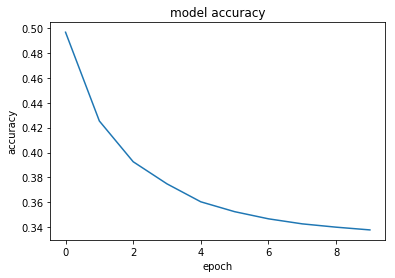

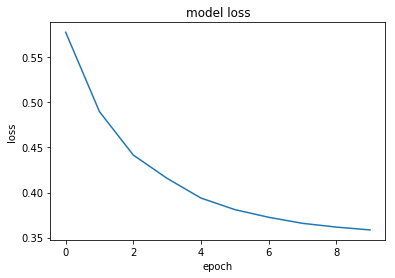

In [312]:
figure()
#print(history3.history.keys())
#plot(history.history['acc'])
#plot(history3.history['acc'])
#plot(history2.history['acc'])
plot(history1.history['MOC'])

title('model accuracy')
ylabel('accuracy')
xlabel('epoch')
figure()
#plot(history.history['loss'])
#plot(history3.history['loss'])
#plot(history2.history['loss'])
plot(history1.history['loss'])

title('model loss')
ylabel('loss')
xlabel('epoch')


In [313]:
loss, acc = model.evaluate(Xdev, Ydev)
print("Dev set accuracy = ", acc)

500/500 [==============================] - 3s 6ms/step
Dev set accuracy =  0.3295139374732971


In [111]:
#%matplotlib notebook

(1, 20, 20, 500, 1)
(1, 20, 20, 1, 1)


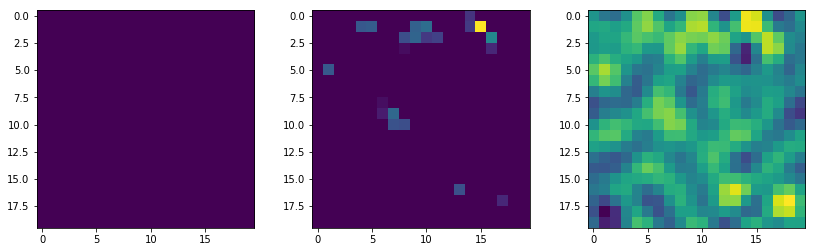

In [310]:
figure(figsize=(14,4))
i = randint(100)
a = load(datadir+"d"+str(i).zfill(4)+".npy");
b = load(datadir+"o2_"+str(i).zfill(4)+".npy");
subplot(1, 3, 1)
imshow(b)

start = randint(T-500)
end = start+500
xt = a[:,:,start:end]
xt = xt/mean(xt.flatten())
xt = ftvaugment(xt,magn)
xt = reshape(xt,(1,magn*width,magn*height,500,1))
print(xt.shape)
y = model.predict(xt)
print(y.shape)
#print(squeeze(y).shape)
subplot(1, 3, 2)
imshow(squeeze(y))
subplot(1, 3, 3)
imshow(sum(xt[0,:,:,:,0],axis=-1))

In [309]:
maxb = []
for i in range(900):
    b = load(datadir+"o2_"+str(i).zfill(4)+".npy");
    maxb.append(max(b.flatten()))

In [184]:
sum(array(maxb)<1e-3)/900


0.11333333333333333

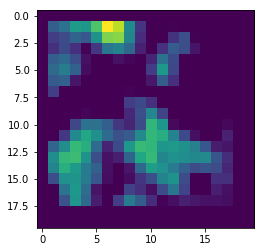

In [50]:
imshow(squeeze(y),vmin= 1.21)

In [ ]:
min(b.flatten())

In [ ]:
mean(((y-b)**2).flatten())

In [ ]:
%matplotlib inline
xt = reshape(a[start:end],(1,2000,1))
plot(model.predict(xt)[0,:,0])

In [ ]:
historybkp = history2